## Assigment 2 <br>
##### Registration number: 22018887<br>
This notebook is focused on how to read the data from the 'Stress-Predict-Dataset' GitHub repository in order to process it and with the help of machine learning algorithms, try to determine when a student may have stress and when not. All the signals where processed from raw and are conformed by 6 different signals of 35 participants. The signals that will be used are mentioned below: <br> 
- EDA = Electrodermal Activity <br>
- HR = Heart Rate <br>
- Temp = Temperature <br> <br>
To begin, the appropriate libraries will be imported:

In [21]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score

***

### 1. Preprocessing
First create some variables to iterate over the files and signals

In [22]:
names = ['S' + str(format(i, '02')) for i in range(36)] # + 1 because range starts at 0
numbers = [i for i in range(len(names))] # Create a similar list to have the number of participant
names.pop(0) # Pop the first element of the list to match the names of the files
names.pop(0) # Pop again because participant number 1 signals are corrupted

numbers.pop(0) # Pop the first element of the list to match the names of the files
numbers.pop(0) # Pop again because participant number 1 signals are corrupted

# Create an empty dictionary that will contain all the processed signals
df_var = {}

# Create a list of the variables and its columns
variables = ['HR', 'EDA','TEMP']

In [23]:
# We will use the first 5 subject to test, to make it faster and easier
# If we wanted to see all the subjects, we would comment the following lines
del names[4:35]
names

['S02', 'S03', 'S04', 'S05']

Then, we will import the timelogs dataframe, this contains all the data about the events where the student was in a stressfull environment or not.

In [24]:
# Import timelogs for visualization
# This DataFrame contains the time logs for each subject responses
timelogs = pd.read_csv('Time_logs.csv')
timelogs = timelogs.drop(0, axis=0) # Drop the first row
timelogs = timelogs.drop(['Session ID', 'Unnamed: 24'], axis=1) # Drop the columns that are not needed

Once imported, all the hours and dates will be converted into UNIX timestamp, since all the signals in the repository works with this time style.

In [25]:
# Convert the time logs to unix timestamps
# This is done to be able to compare the time logs with the data
for column in timelogs.columns:
    unix_timestamps = [] # Create an empty list to store the unix timestamps
    if column != 'Date' and column != 'S. ID.': # If the column is not the date or the subject ID
        timelogs[column] = timelogs.Date + ' ' + timelogs[column] # Concatenate the date and the time
        times = timelogs[column].values.tolist() 
        for date in times:
            dt_obj = datetime.strptime(date, '%d-%b-%Y %H:%M') # Convert the string to datetime object
            unix_timestamps.append(int(dt_obj.timestamp())) # Convert the datetime object to unix timestamp
        timelogs[column] = unix_timestamps # Replace the values in the column with the unix timestamps
timelogs = timelogs.drop(['Date', 'Start Time', 'End Time','Consent','Unnamed: 5'], axis=1) # Drop the columns that are not needed

#### Functions
This next functions are used in the preprocessing and are applied to each signal, they are in charge of using the unix timestamp in order to label according to the timelogs dataframe events.

In [26]:
## ------- Functions ------- ##
def prepare_data(df_old, signal):
    '''
    The function takes a DataFrame and a signal name as input and returns 
    a new DataFrame with the time for each value of the signal in UNIX and 
    a empty label column that will store if is stress or not.
    '''
    df_new = df_old.copy() # Create a copy of the DataFrame
    start_time = df_new.iloc[0,0] # Get the start time of the signal
    # Drop the first two rows because they are not needed
    df_new.drop(0, axis=0, inplace=True) 
    df_new.drop(1, axis=0, inplace=True)
    df_new.reset_index(drop=True, inplace=True) # Reset the index
    df_new.columns = [signal] # Rename the column to the signal name

    # If the signal is HR, use each value as the time for each value
    # If the signal is not HR, use the time of the first value of each 4 values
    # This is done because the other signals are sampled at 4Hz
    if signal == 'HR':
        df_new['time'] = [int(start_time+(i)) for i in range(len(df_new))]
        df_new["label"] = ""
    else:
        df_new['time'] = np.repeat(np.arange(len(df_new)// 4 +1)+int(start_time), 4)[:len(df_new)]
        df_new["label"] = ""
    return df_new

def label(df,subject_number):
    '''
    The function takes a DataFrame and a subject number as input and returns
    a new DataFrame with the labels for each value of the signal depending on the
    timelogs dataframe.
    Not stress = 0
    Stress = 1
    '''
    # Create a flag to know if the value is stress or not
    flag = 0
    index = 1
    for column in range(timelogs.shape[1]):
        next_index = index + 1 # Get the next index to compare the time logs
        if index <= 17: # Check if the index is in the range of the timelogs
            val1 = timelogs.iloc[subject_number-1, index] # Get the value of the timelog
            val2 = timelogs.iloc[subject_number-1, next_index] # Get the value of the next timelog
            if flag == 0: # A flag is used since the stress and not stress values are intercalated
                df.loc[(df['time'] >= val1) & (df['time'] <= val2), 'label'] = 0 # Label all the values between the timelogs as not stress
                flag = 1 
            elif flag == 1:
                df.loc[(df['time'] >= val1) & (df['time'] <= val2), 'label'] = 1 # Label all the values between the timelogs as stress
                flag = 0
        index += 2 # Increase the index by 2 to get the next timelog
    return df

This next loop is in charge of reading all the signals from the repository and apply the necessary preprocessing.

In [27]:
ban = 0 # Create a flag to know if the DataFrame is the first or not
for signal in variables:
    for name in names:
        indx = names.index(name) # Get the index of the name to get the number of the participant
        # Read the csv file and store it in a DataFrame
        df = pd.read_csv(f'https://raw.githubusercontent.com/italha-d/Stress-Predict-Dataset/main/Raw_data/{name}/{signal}.csv', header=None)
        df_new = prepare_data(df, signal) # Prepare the DataFrame using the function
        df_new = label(df_new, numbers[indx]) # Label the DataFrame using the function
        # Replace the empty values with NaN and drop the NaN values
        df_new = df_new.replace('', np.nan, inplace=False) 
        df_new = df_new.dropna(inplace=False)
        if ban == 0: # If the DataFrame is the first, store it in the dictionary
            df_var[signal] = df_new
            ban = 1
        else: # If the DataFrame is not the first, concatenate it with the previous one
            df_var[signal] = pd.concat([df_var[signal], df_new], ignore_index=True)
    ban = 0 # Reset the flag

0.41014734923287255

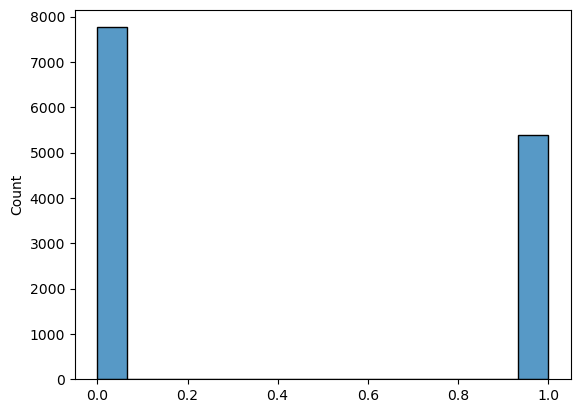

In [28]:
y = df_var['HR'].label.values
_ = sns.histplot(y, kde=False)
df_var['HR'].label.value_counts()
imbalance = df_var['HR'].label.value_counts()[1] / (df_var['HR'].label.value_counts()[0] + df_var['HR'].label.value_counts()[1])
imbalance

Just to visualize data, we can plot the signals of all the particpants together, this will show how different they can be and maybe show a possible visual form to distinguish stress from non-stress events. 
The graph slightly shows the change from participant to participant in the HR and EDA graphs, where it is most noticeable is in the temperature graph.

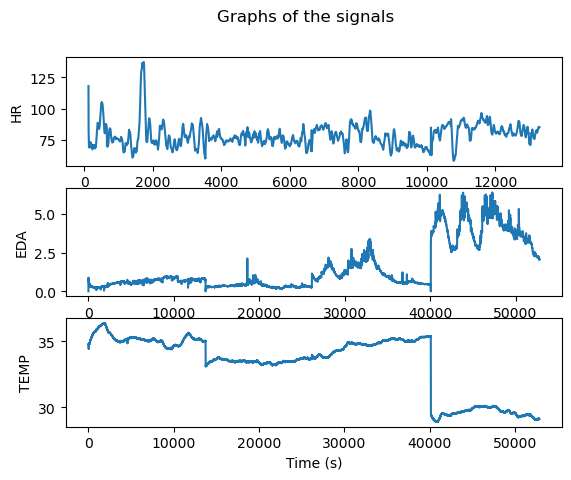

In [62]:
yaxis = pd.DataFrame(df_var.get('HR'))
fig, axs = plt.subplots(3)
fig.suptitle('Graphs of the signals')

for signal in variables:
    ylab = df_var[signal][signal].values
    xaxis = np.linspace(df_var[signal].iloc[0,0], df_var[signal].iloc[0,0]+len(ylab), len(ylab))
    axs[variables.index(signal)].plot(xaxis, ylab)
    axs[variables.index(signal)].set_ylabel(f'{signal}')
    axs[variables.index(signal)].set_xlabel('Time (s)')

***

### 2. Modeling

In order to try to detect stress, a simple machine learning algorithm will be used, as well as a simple Neural Network and they will be compared after to check on the perfomance. 
First, it is necesary to separate each signal from the dictionary, as they are going to be used independently to predict.

In [30]:
df_HR = pd.DataFrame.from_dict(df_var['HR'])
df_EDA = pd.DataFrame.from_dict(df_var['EDA'])
df_TEMP = pd.DataFrame.from_dict(df_var['TEMP'])

Since we are working with timeseries, a normal approach of train-test-split can not be done since it will destroy the timeseries and we will lose information. So in order to work witrh this type of information, we can separate the information by groups according if they are for stress or not, and then apply a sliding window that will gather the data and be inputed into the ML.

In [31]:
# Create a new column to indicate if the value correspond to a stress or not stress group
df_EDA['group'] = (df_EDA['label'] != df_EDA['label'].shift()).cumsum()

# Create a list of groups to exclude from the train set
groups = list(df_EDA['group'].unique())
# Randomly select 50% of the groups to exclude from the train set
exclude_groups = np.random.choice(groups, size=int(0.5*len(groups)), replace=False)
# Create a new column to indicate which rows are in the training set and which are in the test set
df_EDA['set'] = np.where(df_EDA['group'].isin(exclude_groups), 'test', 'train')

# Split the data into training and test sets
x_train_df = df_EDA[df_EDA['set'] == 'train'].drop(columns=['label','time','group','set'])
y_train_df = df_EDA[df_EDA['set'] == 'train'].drop(columns=['EDA','time','group','set'])
x_test_df = df_EDA[df_EDA['set'] == 'test'].drop(columns=['label','time','group','set'])
y_test_df = df_EDA[df_EDA['set'] == 'test'].drop(columns=['EDA','time','group','set'])

Now that the information is separated into train and test, the windowing can be made.

In [41]:
# Create a sliding window of size n for the training data
n = 5
# Create empty lists to store the data
x_train_data = []
y_train_data = []
for i in range(len(x_train_df)-n+1): # We use -n+1 to avoid index out of range
    # Apply the sliding window
    x_window = x_train_df.iloc[i:i+n].values.flatten()
    y_window = y_train_df.iloc[i:i+n].values.flatten()
    # Store the values into the lists
    x_train_data.append(x_window)
    y_train_data.append(y_window)

# Create a sliding window of same size n for the test data
# Create empty lists to store the data
x_test_data = []
y_test_data = []
for i in range(len(x_test_df)-n+1): # We use -n+1 to avoid the last window to be smaller than n
    # Apply the sliding window
    x_window = x_test_df.iloc[i:i+n].values.flatten()
    y_window = y_test_df.iloc[i:i+n].values.flatten()
    # Store the values into the lists
    x_test_data.append(x_window)
    y_test_data.append(y_window)

Now we can apply the models we want to compare to the data, since it is already separated.

In [42]:
# Create the model to use and fit it to the training data
clf = RandomForestClassifier(n_estimators=800, max_depth=8, random_state=42)
clf.fit(x_train_df, y_train_df.values.ravel())
scores = cross_val_score(clf, x_train_df, y_train_df.values.ravel(), cv=8, scoring='f1')  # cross-validation

# Print the F1 score
print("F1: %.2f +/- %.2f" % (scores.mean(), scores.std()))

# Make predictions on the test data
predictions = clf.predict(x_test_df)

# Print the classification report
print(classification_report(y_test_df, predictions))
print(f1_score(y_test_df, predictions))

F1: 0.26 +/- 0.19
              precision    recall  f1-score   support

         0.0       0.51      0.64      0.57     14196
         1.0       0.32      0.21      0.26     11040

    accuracy                           0.45     25236
   macro avg       0.41      0.43      0.41     25236
weighted avg       0.43      0.45      0.43     25236

0.2554728782486789
